In [1]:
# To verify that there is an access to the GPU
!nvidia-smi

Thu May 18 23:28:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Setup and imports

In [2]:
import torch
import cv2
print(f"GPU device is available : {torch.cuda.is_available()}")

GPU device is available : True


Imports packages needed and the functions from pre-processing, utils and save_and_display_image files

In [4]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from tqdm.auto import tqdm
from IPython import display
from IPython.display import Image

!pip install pybboxes
!pip install dataclasses_json
display.clear_output()

from preprocessing import *
from utils import *
from save_and_display_image import *

Creating some directories and downloading the dataset

In [5]:
HOME = "/content"

### Change the value of the variable which_dataset with the dataset you want to download
WHICH_DATASET = "football_players"


if not os.path.isdir(f"{HOME}/data"):
    os.mkdir(f"{HOME}/data")

if not os.path.isdir(f"{HOME}/weights"):
    os.mkdir(f"{HOME}/weights")

%cd {HOME}/data
if WHICH_DATASET == "road_holes":
    !curl -L "https://public.roboflow.com/ds/lJTYDUz2b3?key=RdVEEnrXl9" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
elif WHICH_DATASET == "football_players":
    !curl -L "https://universe.roboflow.com/ds/mevuFgbCLF?key=qXN6lu61jx" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
display.clear_output()

Installation of YOLOv8 (You Only Look Once) and its dependencies

In [6]:
!pip install ultralytics

display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.105 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


Download the pretrained weights of the nano YOLO model

In [7]:
from ultralytics import YOLO

yolo_model = YOLO(f'{HOME}/weights/yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.6MB/s]


Installation of Segment Anything Model (SAM) and other dependencies

In [8]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kvtafwuj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kvtafwuj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=1866fa043d825c240672856185eb34c46d5522914785a1c921c1debcdf1c1966
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wfrj9wa/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


Download the default pretrained weights of the SAM 

In [9]:
if not os.path.isfile(f"{HOME}/weights/sam_vit_h_4b8939.pth"):
    %cd {HOME}/weights
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_WEIGHTS_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

/content/weights


Loading the SAM model

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry["vit_h"](checkpoint=SAM_WEIGHTS_PATH).to(device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

# 2. Task resolution

## 2.1 Prepocessing dataset

In [11]:
GENERIC_ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [12]:
%cd {HOME}
# Reorganizing the train, valid and test directories to put images in subfolder for YOLO model
reorganize_dir_for_yolo("data/train")
reorganize_dir_for_yolo("data/valid")
reorganize_dir_for_yolo("data/test")

/content


In [13]:
# Create txt annotation files for YOLO training
coco_json_to_yolo_txt("data/train", GENERIC_ANNOTATIONS_FILE_NAME)
coco_json_to_yolo_txt("data/valid", GENERIC_ANNOTATIONS_FILE_NAME)
coco_json_to_yolo_txt("data/test", GENERIC_ANNOTATIONS_FILE_NAME)
create_yaml(WHICH_DATASET)

In [14]:
# If you want to augment the data run this cell
image_augmentation(f"{HOME}/data/train", GENERIC_ANNOTATIONS_FILE_NAME, augmentation_nb_per_image=2)

  0%|          | 0/114 [00:00<?, ?it/s]

## 2.2. Finding bounding boxes

### 2.2.1. Training the YOLO model

Loading the smallest YOLO pre-trained model

In [15]:
%cd {HOME}

n_epochs = 30
n_batch = 16
yolo_model.train(task="detect", data=f'{HOME}/custom.yaml', epochs=n_epochs, batch=n_batch, imgsz=640, plots=True, 
                 verbose=True, device='0' if torch.cuda.is_available() else 'cpu')

Ultralytics YOLOv8.0.105 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=/content/weights/yolov8n.pt, data=/content/custom.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fals

/content


100%|██████████| 755k/755k [00:00<00:00, 17.0MB/s]
Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]          

Displaying the confusion matrix (computation of confusion matrix in YOLOv8 does not always work)

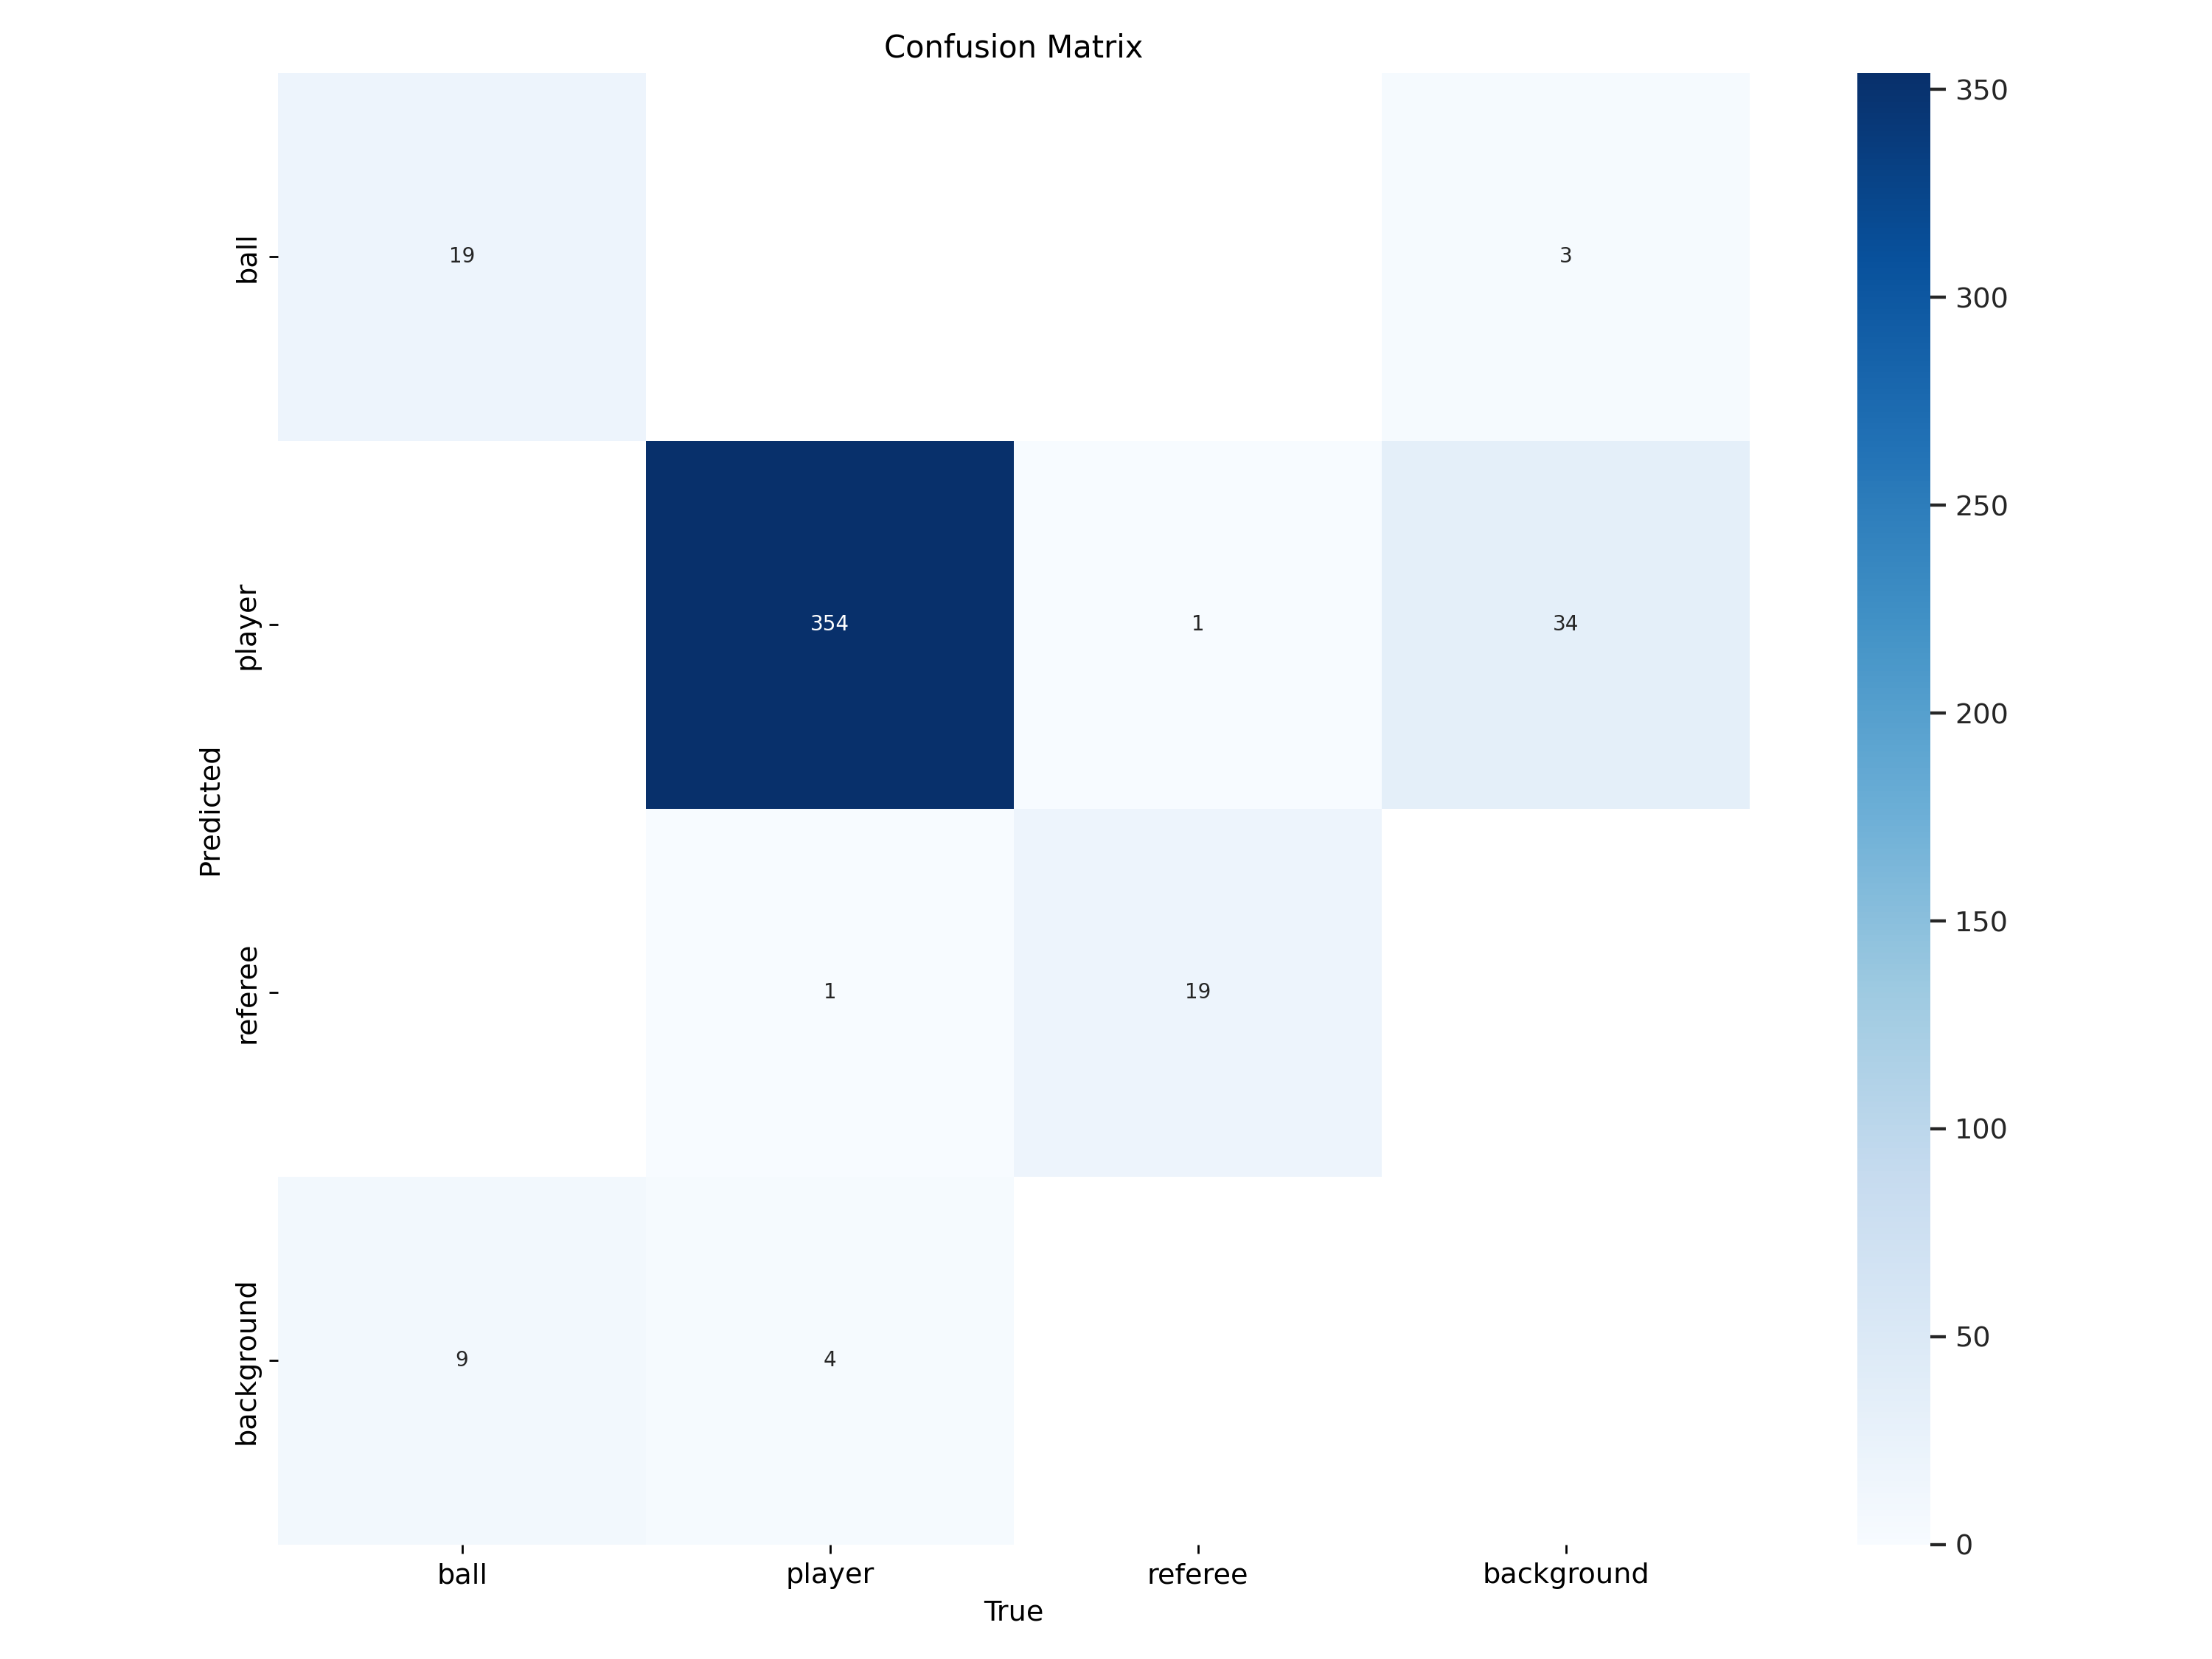

In [16]:
train_folder_number = 0
Image(filename=f'{HOME}/runs/detect/train{train_folder_number if train_folder_number !=0 else ""}/confusion_matrix.png', width=600)

Displaying prediction of the model on a batch of images on the validation set

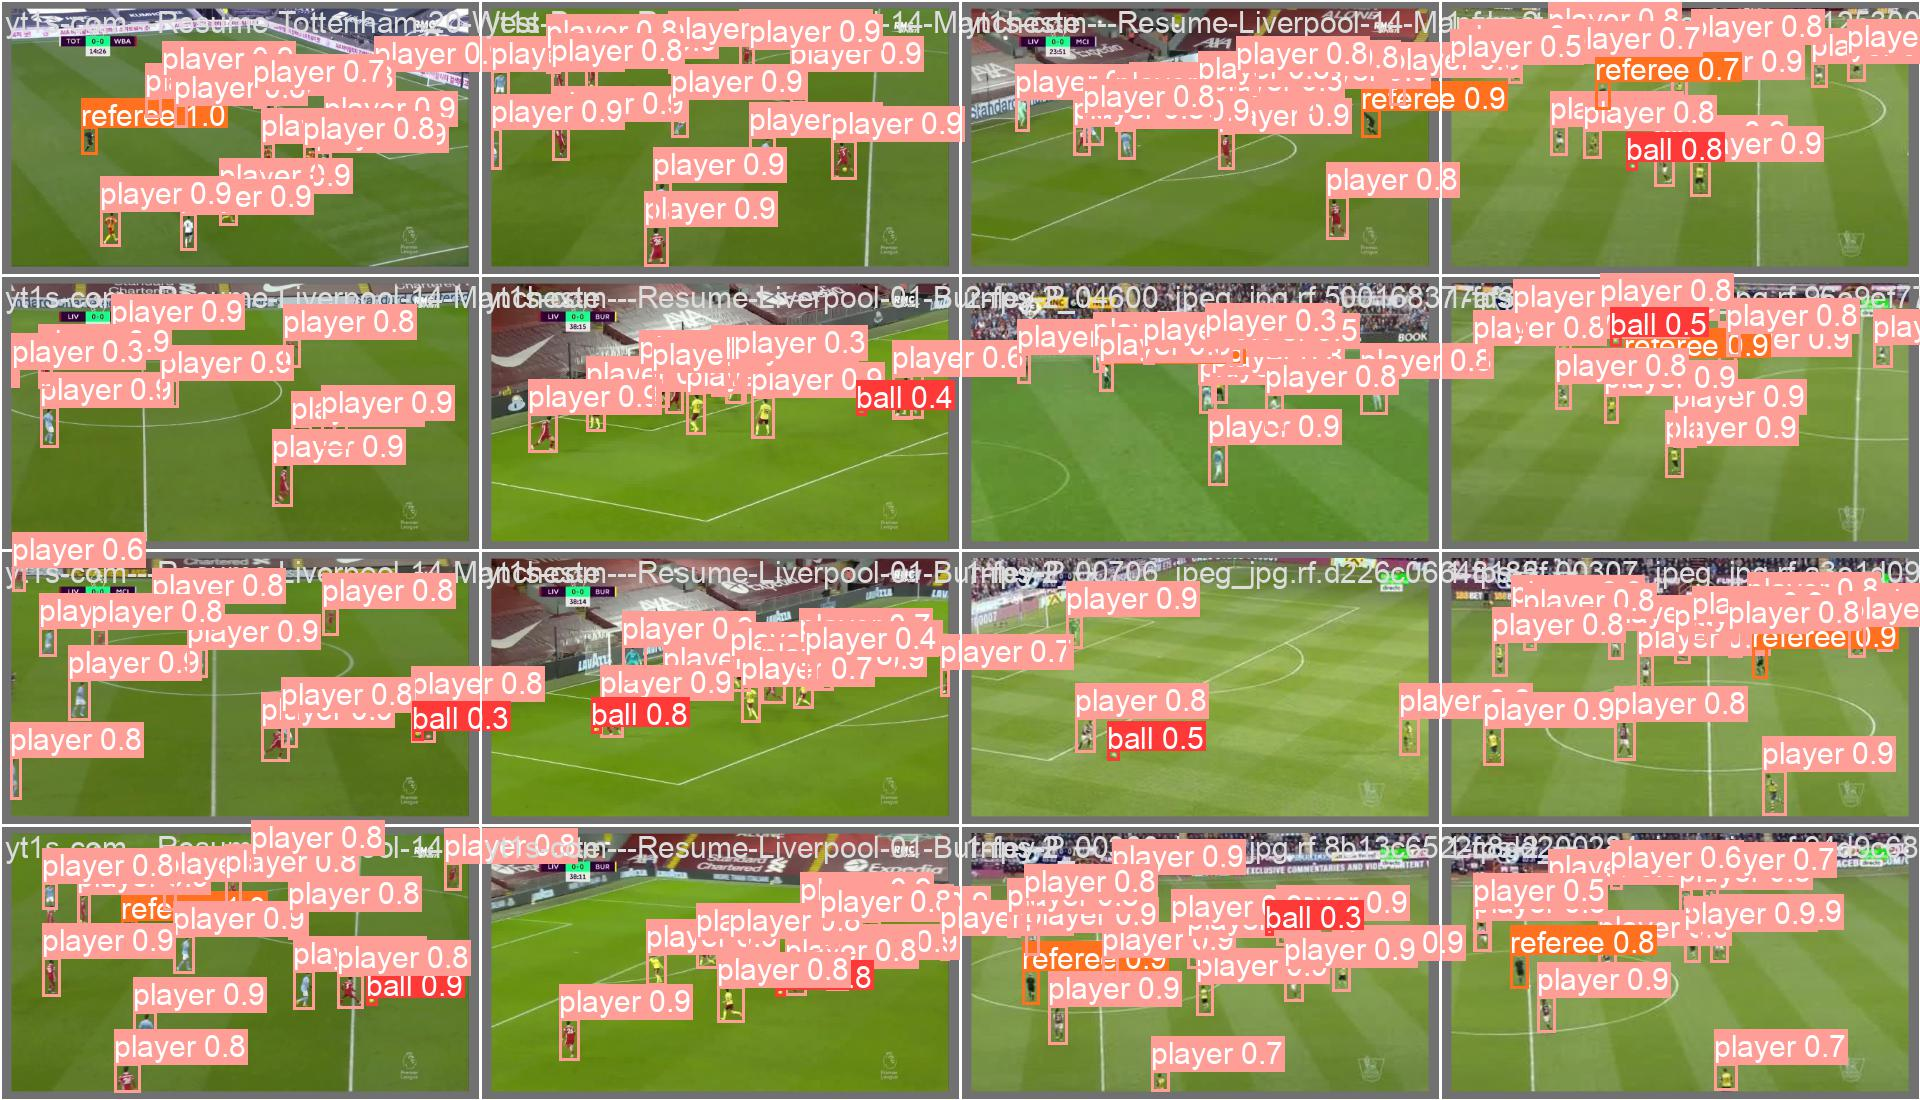

In [17]:
Image(filename=f'{HOME}/runs/detect/train{train_folder_number if train_folder_number !=0 else ""}/val_batch0_pred.jpg', width=600)

### 2.2.2. Predicting bounding boxes on the test set

In [18]:
yolo_results = yolo_model.predict(source=f"{HOME}/data/test/images", save=True, imgsz=640, conf=0.6)
display.clear_output()

In [19]:
yolo_infered_bboxes_in_voc_format = save_yolo_bboxes_to_json(yolo_results, json_file_dir="data/test", returns=True)

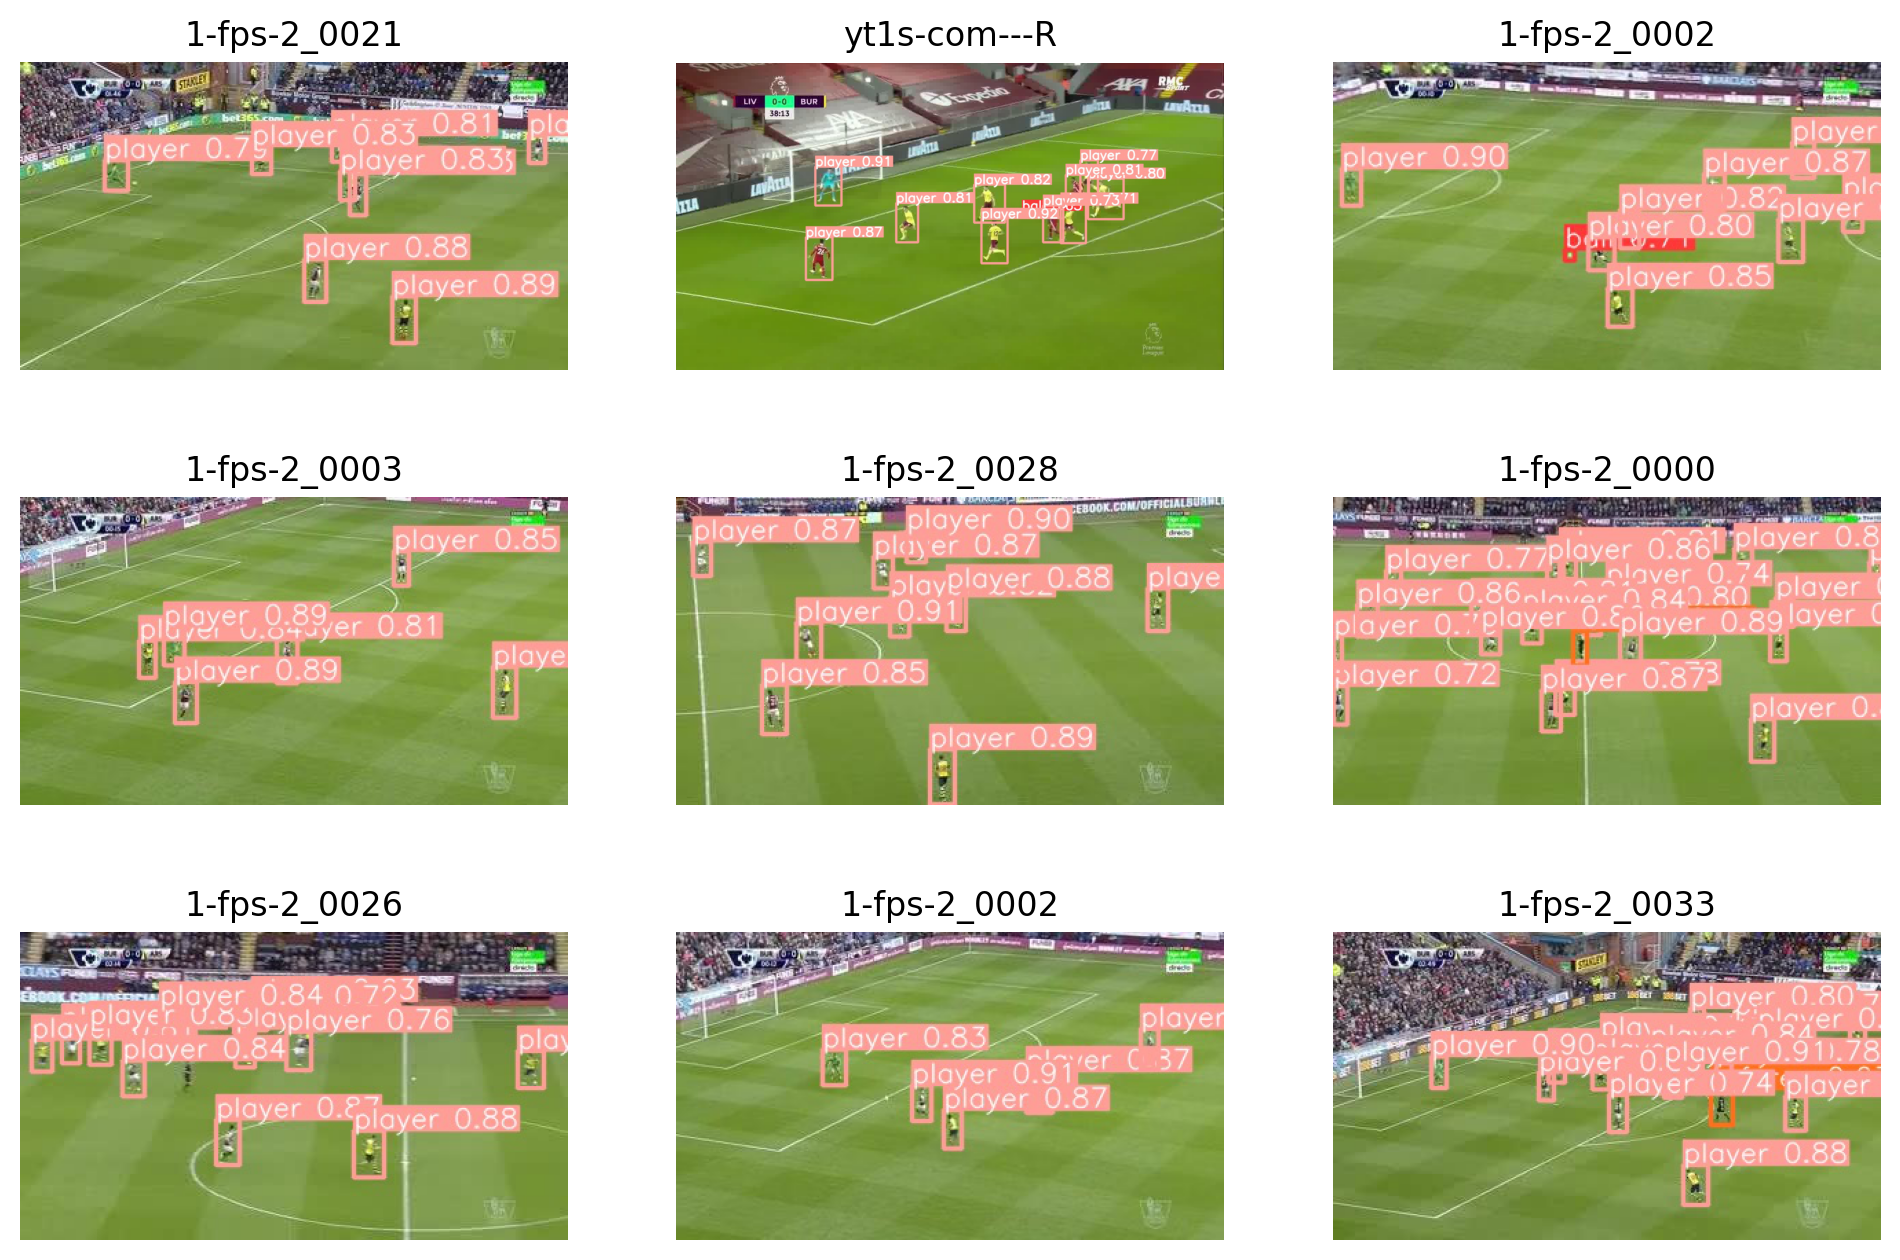

In [25]:
display_random_images_from_dir(dir=f"{HOME}/runs/detect/predict", nb_images_diplayed=9)

## 2.3. Segmentation of all images

Running the SAM model on the test set with the bounding boxes infered by YOLO as entries

In [21]:
DATA_SUBDIR = f"{HOME}/data/test"
SEGMENTATION_PREDICTION_SAVING_DIR = f"{DATA_SUBDIR}/segmented_images"
if not os.path.isdir(SEGMENTATION_PREDICTION_SAVING_DIR):
    os.mkdir(SEGMENTATION_PREDICTION_SAVING_DIR)

# Sometimes needed because of a bug in SAM
torch.use_deterministic_algorithms(mode=True, warn_only=True)

mask_predictor = SamPredictor(sam)

results_insights, sam_inferred_masks = segment_images_and_measure_results(mask_predictor, yolo_infered_bboxes_in_voc_format, 
                                                                          DATA_SUBDIR, GENERIC_ANNOTATIONS_FILE_NAME, 
                                                                          SEGMENTATION_PREDICTION_SAVING_DIR)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x_embed = grid.cumsum(dim=1) - 0.5


## 2.4. Results 

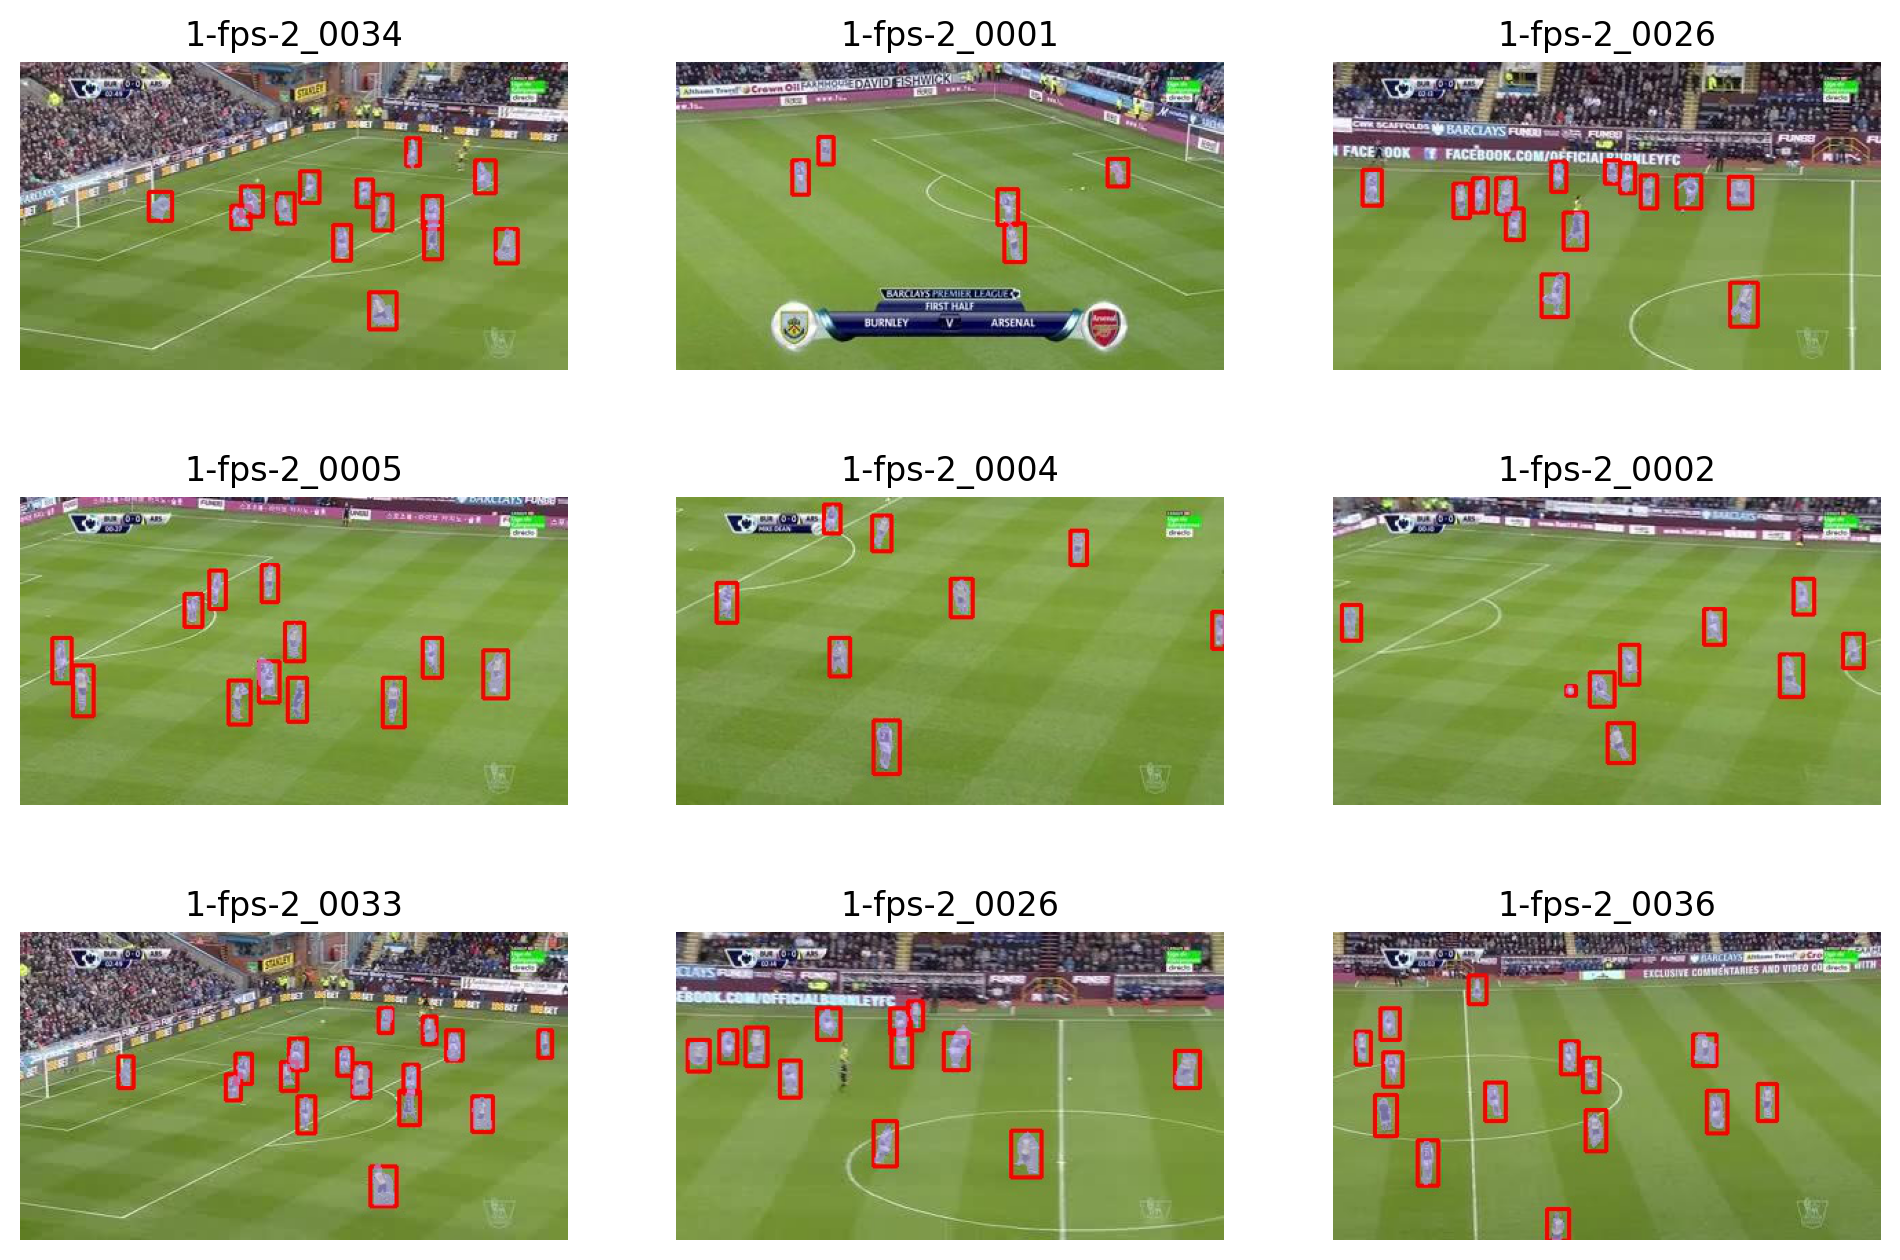

In [26]:
display_random_images_from_dir(dir=SEGMENTATION_PREDICTION_SAVING_DIR, nb_images_diplayed=9)

Computing average accuracies and print out results

In [23]:
all_area_position_accuracy_rate = []
all_area_accuracy_rate = []
all_quality_predictions = []
for key in results_insights.keys():
    if "area_position_accuracy_rate" in results_insights[key].keys():
        all_area_position_accuracy_rate = all_area_position_accuracy_rate + results_insights[key]["area_position_accuracy_rate"]
    if "area_accuracy_rate" in results_insights[key].keys():
        all_area_accuracy_rate = all_area_accuracy_rate + results_insights[key]["area_accuracy_rate"]
    if "quality_predictions" in results_insights[key].keys():
        all_quality_predictions = all_quality_predictions + results_insights[key]["quality_predictions"]

if all_area_position_accuracy_rate : print(f"The average accuracy on the areas' position is : {round(np.mean(all_area_position_accuracy_rate) * 100, 2)}%")
if all_area_accuracy_rate : print(f"The average accuracy on the area sizes is : {round(np.mean(all_area_accuracy_rate) * 100, 2)}%")
print(f"The average quality predictions by the model on the segemeneted areas is : {round(np.mean(all_quality_predictions) * 100, 2)}%")

The average quality predictions by the model on the segemeneted areas is : 88.41%


### Comparision between the annotations and the predictions on 1 image

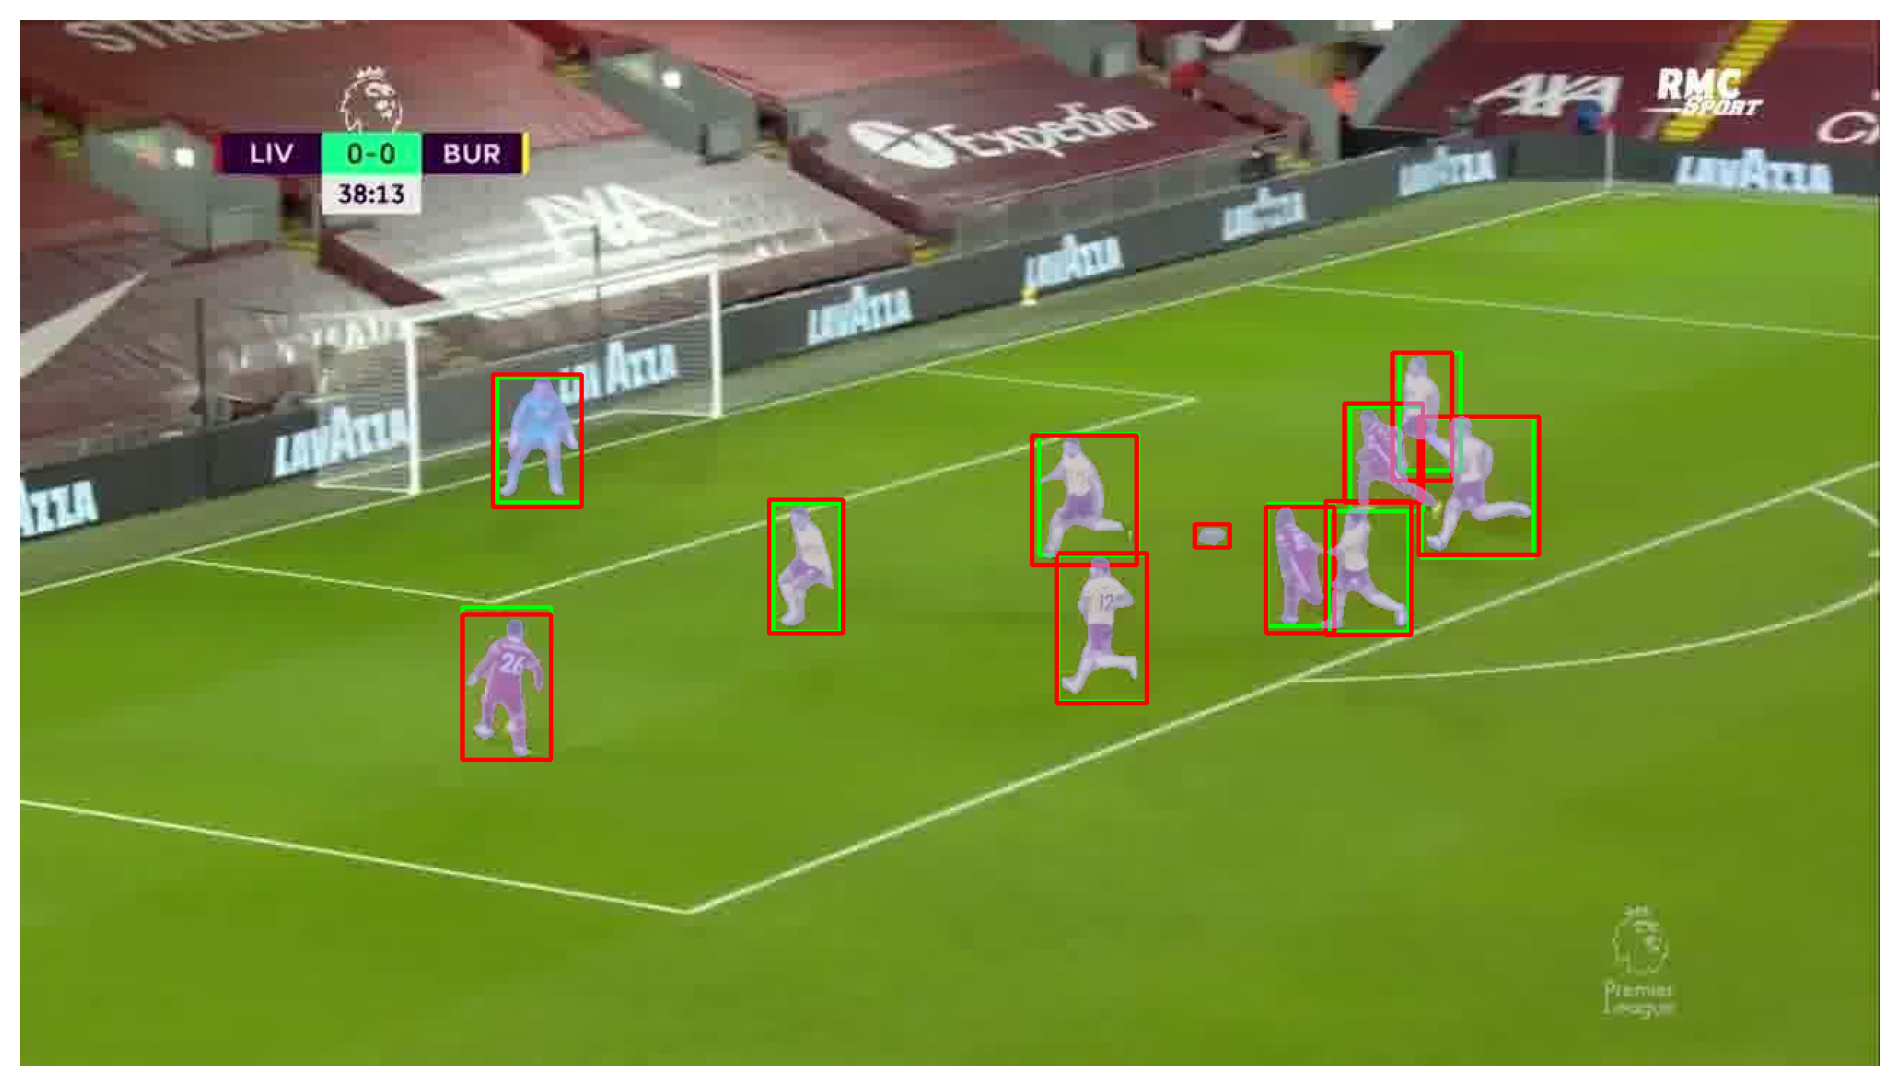

In [28]:
# Choose the image position in the list TEST_IMAGES 
NB = 13

# create list of images names
list_images = os.listdir(f"{DATA_SUBDIR}/images")
list_images = [image_name for image_name in list_images if image_name[-3:]=="jpg"]

# diplay the image 
display_image_detections_comparision(DATA_SUBDIR, list_images[NB], GENERIC_ANNOTATIONS_FILE_NAME, sam_inferred_masks, 
                                      yolo_infered_bboxes_in_voc_format, bboxes_format="voc")

# Legend : the green rectangles are the annotated bounding boxes (from the COCO json)
#          the red rectangles are the bounding boxes inferred by YOLOv8
#          the pastel purple (translucent) surfaces are the masks inferred by SAM on the YOLOv8 bounding boxes
#          the blue polygon lines are the annotated segmentation lines (from the COCO json) - not always present